# 1. filter

In [2]:
# 一元属性
from shapely.geometry import Point
from operator import attrgetter

empties = filter(attrgetter('is_empty'), [Point(), Point(0, 0)])
len(list(empties))

1

In [8]:
# 二元关系
from shapely.geometry import LineString

coords = [(0, 0), (1, 1)]
line = LineString(coords)
contained = list(filter(line.contains, [Point(0, 0), Point(0.5, 0.5), Point(1, 1)]))
len(contained)

1

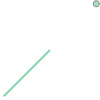

In [46]:
# collection对象遍历
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
x = a.intersection(b)
x

In [48]:
for geom in list(x.geoms):
    print(geom)

LINESTRING (0 0, 1 1)
POINT (2 2)


# 2. 关系运算

### equals

In [6]:
from shapely.geometry import Point, LineString, Polygon, MultiLineString

a = LineString([(0, 0), (1, 1)])
b = LineString([(0, 0), (0.5, 0.5), (1, 1)])
c = LineString([(0, 0), (0, 0), (1, 1)])

In [12]:
a.equals(b)

True

In [13]:
b.equals(c)

True

### contains, covers

In [20]:
coords = [(0, 0), (1, 1)]
LineString(coords).contains(Point(0.5, 0.5))

True

In [16]:
LineString(coords).contains(Point(1.0, 1.0))

False

In [17]:
LineString(coords).covers(Point(1.0, 1.0))

True

### within

In [19]:
Point(0.5, 0.5).within(LineString(coords))

True

### crosses: intersects but not contain

In [21]:
coords = [(0, 0), (1, 1)]
LineString(coords).crosses(LineString([(0, 1), (1, 0)]))

True

In [22]:
LineString(coords).crosses(Point(0.5, 0.5))

False

### disjoint: not intersect at all

In [23]:
Point(0, 0).disjoint(Point(1, 1))

True

### intersect: have any boundary or interior point in common

In [25]:
Point(0, 0).intersects(Point(1, 1))

False

### overlaps:  the intersection has the same dimension

In [26]:
a = LineString([(0, 0), (1, 1)])
b = LineString([(0.5, 0.5), (2, 2)])
c = LineString([(1, 1), (2, 2)])

a.overlaps(b)

True

In [27]:
a.overlaps(c)

False

### touches: have boundary points in common and their interiors do not intersect

In [29]:
a = LineString([(0, 0), (1, 1)])
b = LineString([(1, 1), (2, 2)])
a.touches(b)

True

### relate: Returns a string representation of the DE-9IM matrix of relationships

DE-9IM，全称是Dimensionally Extended nine-Intersection Model (DE-9IM)，是一种拓扑模型，用于描述两个几何图形空间关系的一种标准。模型将每个几何图形分为三部分：外部exterior,边界boundary和内部interior。
3x3矩阵枚举了9种 a INTERSECTION b 关系
https://en.wikipedia.org/wiki/DE-9IM

![20230129101132](https://appen-pe.oss-cn-shanghai.aliyuncs.com/imgupload/20230129101132.png)

### Touches
$$
\begin{equation}
    \begin{bmatrix}
    F & T & * \\
    * & * & * \\
    * & * & *
    \end{bmatrix}
    \begin{bmatrix}
    F & * & * \\
    T & * & * \\
    * & * & *
    \end{bmatrix}
    \begin{bmatrix}
    F & * & * \\
    * & T & * \\
    * & * & *
    \end{bmatrix}
\end{equation}
$$

pattern: $FT******* | F**T***** | F***T****$

In [4]:
im = Point(0, 0).relate(LineString([(0, 0), (1, 1)]))
print(im)

F0FFFF102


In [7]:
point = Point(0.5, 0.5)
square = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
square.relate_pattern(point, 'T*****FF*')

True

In [8]:
point.within(square)

True

In [9]:
point.relate(square)

'0FFFFF212'

In [10]:
square.relate(point)

'0F2FF1FF2'

# 3. 空间计算

### boundary
几何对象的边集（拓扑维度减一）

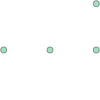

In [24]:
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString

coords = [[(0, 0), (1, 1)], [(-1, 0), (1, 0)]]
lines = MultiLineString(coords)
lines.boundary

In [14]:
list(lines.boundary.geoms)

[<POINT (-1 0)>, <POINT (0 0)>, <POINT (1 0)>, <POINT (1 1)>]

### centroid
geometric centroid point

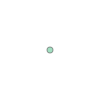

In [16]:
LineString([(0, 0), (1, 1)]).centroid

### 点集运算：差集，交集，对称差集，并集

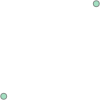

In [22]:
Point(1, 1).buffer(1.5) # 圆心(1,1)，半径为1.5
Point(2, 1).buffer(1.5)
a.difference(b)
a.intersection(b)
a.symmetric_difference(b)
a.union(b)
a.boundary.union(b.boundary)

### convex_hull
凸包

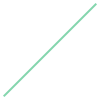

In [25]:
MultiPoint([(0, 0), (1, 1)]).convex_hull

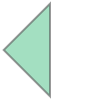

In [26]:
MultiPoint([(0, 0), (1, 1), (1, -1)]).convex_hull

### envelope
求bbox

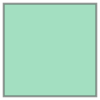

In [28]:
MultiPoint([(0, 0), (1, 1)]).envelope

### minimum_rotated_rectangle
求最小包围矩形(带旋转角度)

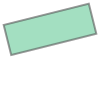

In [30]:
MultiPoint([(0,0),(1,1),(2,0.5)]).minimum_rotated_rectangle

# 4. 批处理

### prep
测试一个多边形含有多个点，当点集的数量很大时，推荐使用prep

In [33]:
from shapely.prepared import prep
points = [...] # large list of points
polygon = Point(0.0, 0.0).buffer(1.0)
prepared_polygon = prep(polygon)
hits = filter(prepared_polygon.contains, points)

# 5. 诊断

### explain_validity
输出多边形valid诊断信息

In [43]:
from shapely.validation import explain_validity

coords = [(0, 0), (0, 2), (1, 1), (2, 2), (2, 0), (1, 1), (0, 0)]
p = Polygon(coords)
print(p.is_valid)
print(explain_validity(p))

False
Ring Self-intersection[1 1]


### make_valid
当输入的多边形是invalid的，将分割成多个valid对象返回

In [49]:
from shapely.validation import make_valid

coords = [(0, 0), (0, 2), (1, 1), (2, 2), (2, 0), (1, 1), (0, 0)]
p = Polygon(coords)
q = make_valid(p)
list(q.geoms)

[<POLYGON ((1 1, 0 0, 0 2, 1 1))>, <POLYGON ((2 0, 1 1, 2 2, 2 0))>]

In [50]:
coords = [(0, 2), (0, 1), (2, 0), (0, 0), (0, 2)]
p = Polygon(coords)
q = make_valid(p)
list(q.geoms)

[<POLYGON ((2 0, 0 0, 0 1, 2 0))>, <LINESTRING (0 2, 0 1)>]